In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Pg 145
# J&J Quarterly EPS since January 1960 to  december 1980
df = pd.read_csv('../data/jj.csv')
df.tail() # shape (84, 2)

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [3]:
train = df.iloc[:-4]
test= df.iloc[-4:]

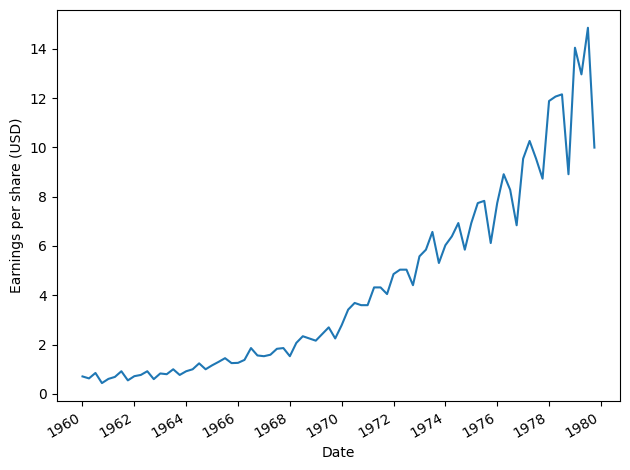

In [4]:
# Figure 7.5 in pg 147

fig, ax = plt.subplots()

ax.plot(train.date, train['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()


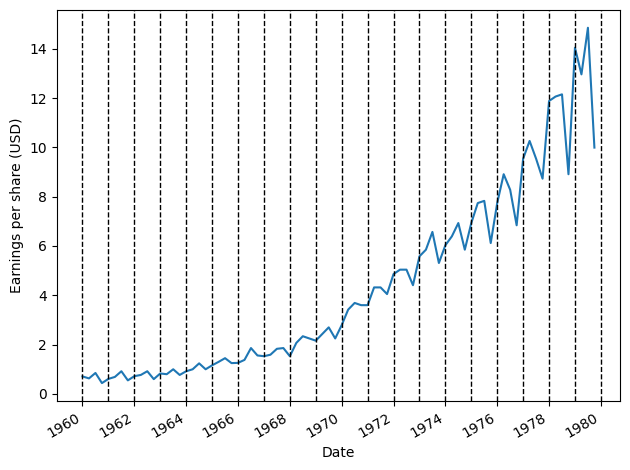

In [5]:
fig, ax = plt.subplots()

ax.plot(train.date, train['data'])
for i in np.arange(0, 84, 4):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 84, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

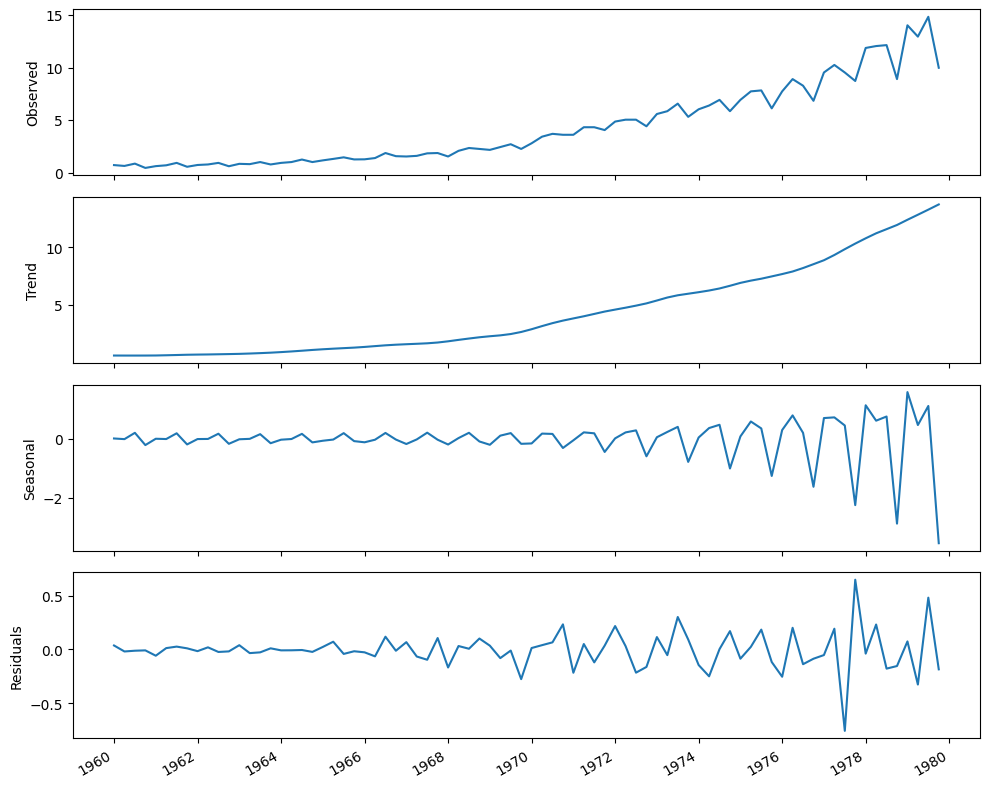

In [6]:
decomposition = STL(train['data'], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 84, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
ad_fuller_result = adfuller(train['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 4.990525443391484
p-value: 1.0


In [8]:
df_diff = np.diff(train['data'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.0549818780548506
p-value: 0.9948134914948294


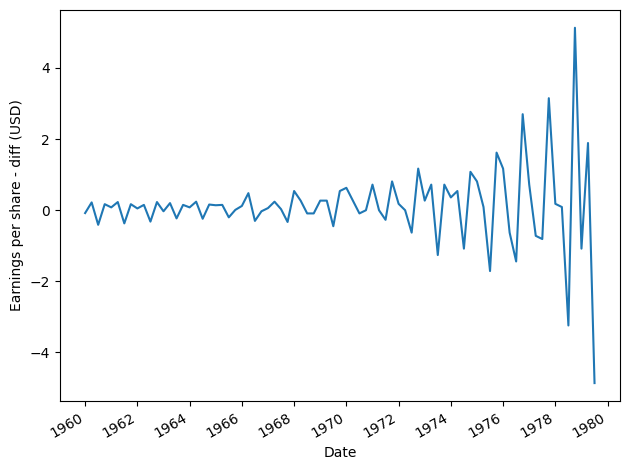

In [9]:
fig, ax = plt.subplots()

ax.plot(train['date'][1:], df_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [10]:
df_diff_diff = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.7833124530769835
p-value: 2.467846485128343e-09


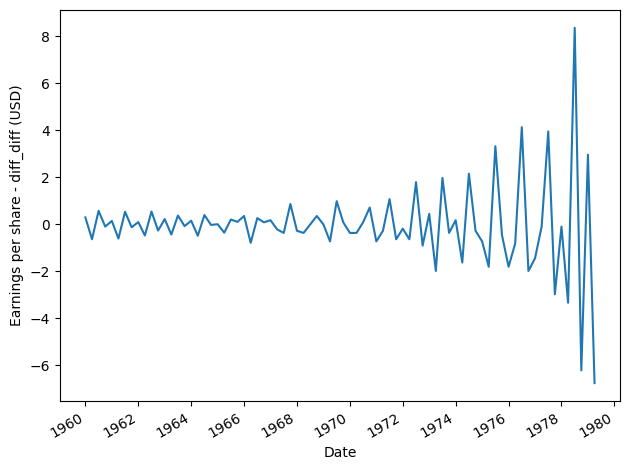

In [11]:
fig, ax = plt.subplots()

ax.plot(train['date'][2:], df_diff_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff_diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## d=2, D=0

In [12]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [13]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

d = 2
D = 0
s = 4

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

SARIMA_result_df = optimize_SARIMA(train['data'], SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 3, 1, 2)",18.000000
1,"(2, 4, 1, 0)",106.293282
2,"(1, 4, 1, 0)",106.532493
3,"(3, 2, 1, 0)",107.079593
4,"(3, 1, 3, 1)",107.319245
...,...,...
435,"(0, 0, 0, 2)",257.460340
436,"(0, 0, 0, 1)",274.474465
437,"(2, 0, 0, 0)",280.299907
438,"(1, 0, 0, 0)",280.389386


In [14]:
SARIMA_result_df[:20]

,"(p,q,P,Q)",AIC
0,"(2, 3, 1, 2)",18.000000
1,"(2, 4, 1, 0)",106.293282
2,"(1, 4, 1, 0)",106.532493
3,"(3, 2, 1, 0)",107.079593
4,"(3, 1, 3, 1)",107.319245
5,"(1, 3, 1, 0)",107.688646
6,"(3, 1, 3, 2)",107.861947
7,"(2, 4, 2, 0)",107.939101
8,"(1, 3, 2, 1)",108.022312
9,"(3, 2, 3, 2)",108.172132


	(p,q,P,Q)	AIC  
0	(2, 3, 1, 2)	18.000000  
1	(2, 4, 1, 0)	106.293282  
2	(1, 4, 1, 0)	106.532493  
3	(3, 2, 1, 0)	107.079593  
4	(3, 1, 3, 1)	107.319245  
5	(1, 3, 1, 0)	107.688646  
6	(3, 1, 3, 2)	107.861947  
7	(2, 4, 2, 0)	107.939101  
8	(1, 3, 2, 1)	108.022312  
9	(3, 2, 3, 2)	108.172132  
10	(3, 1, 1, 1)	108.424740  
11	(3, 1, 1, 0)	108.459241  
12	(3, 1, 2, 2)	108.511142  
13	(3, 1, 4, 1)	108.607496  
14	(3, 1, 2, 0)	108.627967  
15	(3, 3, 1, 0)	108.675711  
16	(1, 3, 1, 4)	108.695703  
17	(3, 4, 2, 0)	108.845994  
18	(3, 2, 1, 1)	109.037057  
19	(3, 2, 3, 1)	109.105855  

***************************************************************************
Pick a Model and analyze residuals

SARIMA(2,2,3)(1,0,2)_4, which has the lowest AIC: Residuals are correlated  
SARIMA(2,2,4)(1,0,0)_4: Residuals are correlated  
SARIMA(1,2,4)(1,0,0)_4: Residuals are correlated  
SARIMA(3,2,2)(1,0,0)_4: Residuals are correlated    
SARIMA(3,2,1)(3,0,1)_4: Residuals are correlated    

In [27]:
SARIMA_model = SARIMAX(train['data'], order=(3,2,1), seasonal_order=(3,0,1,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              data   No. Observations:                   80
Model:             SARIMAX(3, 2, 1)x(3, 0, 1, 4)   Log Likelihood                -124.856
Date:                           Tue, 10 Feb 2026   AIC                            267.712
Time:                                   19:28:25   BIC                            288.923
Sample:                                        0   HQIC                           276.203
                                            - 80                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0047      0.438      0.011      0.992      -0.855       0.864
ar.L2         -0.0001      0.569     -0.000

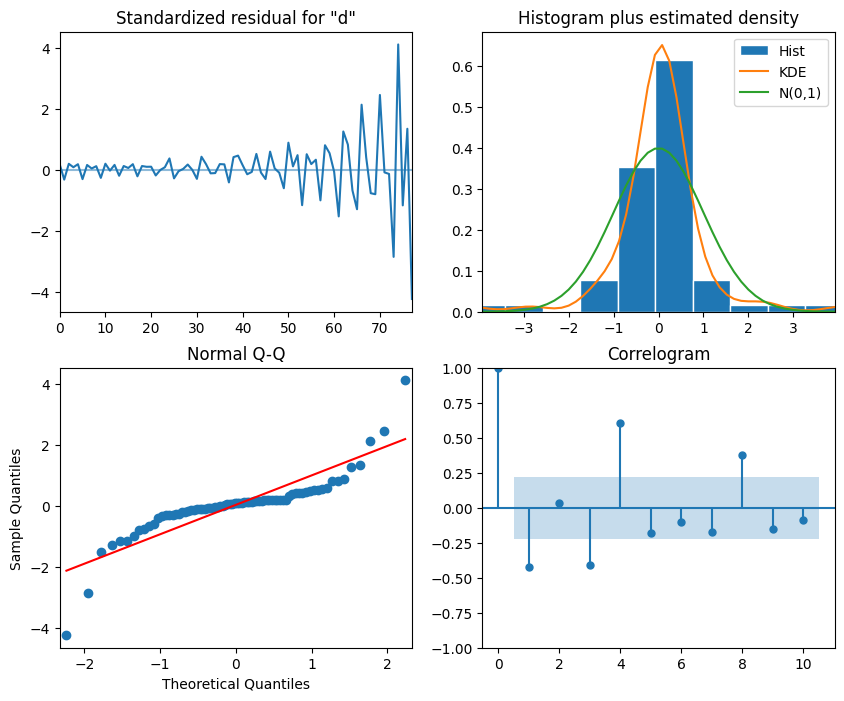

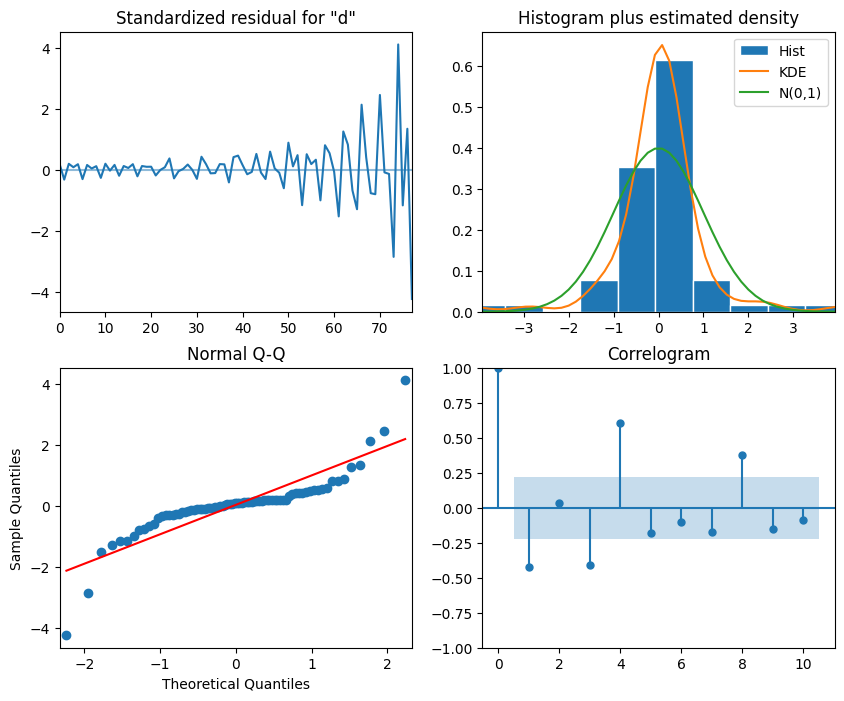

In [28]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [29]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,14.836963,1.172155e-04
2,14.933672,5.717343e-04
3,29.329239,1.909600e-06
4,61.022172,1.768753e-12
5,63.782342,2.004344e-12
6,64.600257,5.205780e-12
7,67.480199,4.764782e-12
8,80.523209,3.835936e-14
9,82.714666,4.660444e-14
10,83.342252,1.107285e-13


Residuals are non correlated

I pick SARIMA(2,2,3)(1,0,2)_4, even if correlated

*******************************************************************************************
Forecast with model

In [30]:
SARIMA_model = SARIMAX(train['data'], order=(2,2,3), seasonal_order=(1,0,2,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

#print(SARIMA_model_fit.summary())

In [31]:
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [32]:
SARIMA_pred = SARIMA_model_fit.get_prediction(80, 83).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,date,data,naive_seasonal,SARIMA_pred
80,1980-01-01,16.20,14.04,14.559926
81,1980-04-01,14.67,12.96,12.619060
82,1980-07-02,16.02,14.85,14.441885
83,1980-10-01,11.61,9.99,11.084970


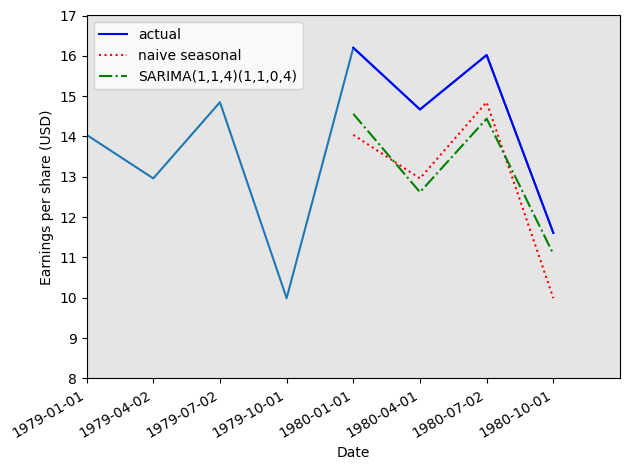

In [33]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
#ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(1,1,4)(1,1,0,4)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(75, 84, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(76, 84)
ax.set_ylim(8, 17)

fig.autofmt_xdate()
plt.tight_layout()


In [34]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_SARIMA)

11.561658552433654 9.61938532013137


CH07, ARIMA(3,2,3): 1.73% off

CH08_exercise_8.5.1_d=1_D=1, SARIMA(1,1,4)(1,1,0,4)_4: 3.49% off

CH08_exercise_8.5.1_d=0_D=1: 11.48% off

CH08_exercise_8.5.1_d=2_D=0, SARIMA(2,2,3)(1,0,2)_4: 9.62% off

